In [1]:
#Importer les bibliothèque

import pandas as pd

import plotly as plt

import numpy as np

from sklearn.preprocessing import StandardScaler

##### Prétraitement

In [2]:
#Lire les données

df = pd.read_csv("Prod.csv")
df.index.name = 'Date'
df.columns = ["Production"]

In [3]:
#Afficher les données mensuelles
df

,Production
Date,
1962-01,589
1962-02,561
1962-03,640
1962-04,656
1962-05,727
...,...
1975-08,858
1975-09,817
1975-10,827


In [4]:
#Afficher un extrait : du début et de la fin

pd.concat((df.iloc[:10], df.iloc[-10:]))

,Production
Date,
1962-01,589
1962-02,561
1962-03,640
1962-04,656
1962-05,727
1962-06,697
1962-07,640
1962-08,599
1962-09,568


<AxesSubplot: xlabel='Date'>

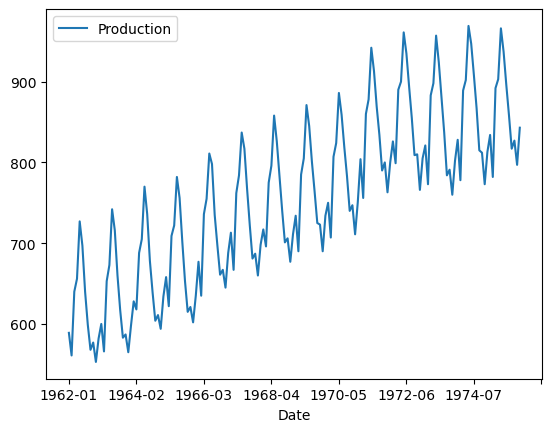

In [5]:
#Tracer la courbe de la production en fonction de la date

df.plot()

##### Décomposer la  série temporelle en ses composantes de tendance, saisonnière et résiduelle.

In [6]:
# Importer la bibliothèque  seasonal_decompose

from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
# Tracer les composantes de la série

df.index = pd.DatetimeIndex(df.index)
result = seasonal_decompose(df)
plt.plot(result.trend, kind="line")

In [8]:
plt.plot(result.seasonal, kind="line")

In [9]:
plt.plot(result.resid, kind="line")

In [10]:
# Afficher le nombre de ligne du dataset

print(f"Nombre de lignes du dataframe : {df.shape[0]}")

Nombre de lignes du dataframe : 168


##### Diviser le dataset en train et test datasets

In [11]:
# On prend les première 156 valeurs pour l'entraienemnt 

train_df = df.iloc[:156]
test_df = df.iloc[156:]

##### Standardisation des données

In [12]:
# Définir le scaler

scaler = StandardScaler()

In [13]:
#Afficher un extrait des données avant la standardisation 

train_df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [14]:
#Standardisation

train_df['Production'] = scaler.fit_transform(train_df)



test_df['Production'] = scaler.transform(test_df)

C:\Users\antoine.lecroart\AppData\Local\Temp\ipykernel_2196\3841802764.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\antoine.lecroart\AppData\Local\Temp\ipykernel_2196\3841802764.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
#Afficher un extrait des données après la standardisation

train_df.head()

,Production
Date,
1962-01-01,-1.574737
1962-02-01,-1.854862
1962-03-01,-1.064511
1962-04-01,-0.904440
1962-05-01,-0.194125


In [16]:
## Importer la bibliothèque TimeseriesGenerator

from keras.preprocessing.sequence import TimeseriesGenerator

## Expliquer le rôle de cette bibliothèque


# TimeseriesGenerator permet de transformer automatiquement les données de séries temporelles univariées et multivariées en échantillons, 
# prêts à entraîner des modèles de deep learning.


In [17]:
# Definissez le "generator" comme suit: 3 inputs (pour trois mois) , 1 feature

generator_3month = TimeseriesGenerator(train_df["Production"], train_df["Production"], length = 3, batch_size = 1)

In [18]:
# extrait un seul lot (batch) d'entrée et de sortie à partir du générateur et affiche les données d'entrée (X) et les valeurs cibles (y) correspondantes.

input, output = generator_3month[0]

print(f"Entrées : {input[0]}\nSortie : {output}")

Entrées : [-1.57473738 -1.8548617  -1.06451092]
Sortie : [-0.90443988]


In [19]:
## Faites la même chose mais pour 12 mois 

generator_12month = TimeseriesGenerator(train_df["Production"], train_df["Production"], length = 12, batch_size = 1)

input, output = generator_12month[0]

print(f"Entrées : {input[0]}\nSortie : {output}")

Entrées : [-1.57473738 -1.8548617  -1.06451092 -0.90443988 -0.19412462 -0.49425783
 -1.06451092 -1.47469297 -1.78483062 -1.69479066 -1.93489723 -1.64476846]
Sortie : [-1.46468853]


##### Prédire avec un LSTM 

In [20]:
# Bibliothèques

from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import LSTM

In [21]:
# définir le modèle 

model = Sequential()
model.add(LSTM(32, input_dim=(1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
# Affiche un résumé détaillé du modèle

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Entrainez le modèle

history = model.fit(generator_3month, epochs=200, verbose=2)

Epoch 1/200
153/153 - 1s - loss: 0.5903 - 1s/epoch - 9ms/step
Epoch 2/200
153/153 - 0s - loss: 0.3653 - 190ms/epoch - 1ms/step
Epoch 3/200
153/153 - 0s - loss: 0.3380 - 191ms/epoch - 1ms/step
Epoch 4/200
153/153 - 0s - loss: 0.3060 - 192ms/epoch - 1ms/step
Epoch 5/200
153/153 - 0s - loss: 0.2711 - 193ms/epoch - 1ms/step
Epoch 6/200
153/153 - 0s - loss: 0.2328 - 191ms/epoch - 1ms/step
Epoch 7/200
153/153 - 0s - loss: 0.2037 - 194ms/epoch - 1ms/step
Epoch 8/200
153/153 - 0s - loss: 0.1899 - 192ms/epoch - 1ms/step
Epoch 9/200
153/153 - 0s - loss: 0.1870 - 192ms/epoch - 1ms/step
Epoch 10/200
153/153 - 0s - loss: 0.1715 - 192ms/epoch - 1ms/step
Epoch 11/200
153/153 - 0s - loss: 0.1813 - 189ms/epoch - 1ms/step
Epoch 12/200
153/153 - 0s - loss: 0.1731 - 190ms/epoch - 1ms/step
Epoch 13/200
153/153 - 0s - loss: 0.1729 - 187ms/epoch - 1ms/step
Epoch 14/200
153/153 - 0s - loss: 0.1713 - 190ms/epoch - 1ms/step
Epoch 15/200
153/153 - 0s - loss: 0.1737 - 190ms/epoch - 1ms/step
Epoch 16/200
153/153 -

In [24]:
# Définir la fonction perte et tracez là

losses = history.history['loss']

plt.plot(losses, kind = 'line')

In [25]:
# Sélectionne les 12 dernières valeurs du train set et faites la prédiction 

pred = model.predict(test_df)
pred_df = test_df.copy()
pred_df['Production'] = pred

1/1 [==============================] - 0s 288ms/step


In [26]:
##Déterminer les vrais prédiction 

test_df

,Production
Date,
1975-01-01,0.876350
1975-02-01,0.356120
1975-03-01,1.456608
1975-04-01,1.566657
1975-05-01,2.196937
1975-06-01,1.906808
1975-07-01,1.496626
1975-08-01,1.116457
1975-09-01,0.706275


In [27]:
## Transformation inverse des données

pred_df['Production'] = scaler.inverse_transform(np.array(pred_df['Production']).reshape(-1, 1))
test_df['Production'] = scaler.inverse_transform(np.array(test_df['Production']).reshape(-1, 1))

C:\Users\antoine.lecroart\AppData\Local\Temp\ipykernel_2196\2121895561.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
# Tracer les vrais prédiction
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x = test_df.index, y = test_df['Production'], name = "Valeurs", line = dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x = pred_df.index, y = pred_df['Production'], name = "Prédictions", line = dict(color='red', width=4, dash='dash')))


In [29]:
# Calculer l'erreur Moyenne Quadratique et interpréter

from sklearn.metrics import mean_squared_error

print(f"Erreur Moyenne Quadratique : {mean_squared_error(test_df['Production'], pred_df['Production'], squared=False)}")

Erreur Moyenne Quadratique : 4.078330469885347
